In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import roc_auc_score, accuracy_score

In [85]:
from xgboost import XGBClassifier
df = pd.read_csv('/Users/guenounraphael/Desktop/HEC/Algo_Fairness/dataproject2025.csv')

In [86]:
def advanced_feature_engineering(df):
    """Feature engineering plus sophistiqué"""
    df_processed = df.copy()
    
    exclude_columns = [
        'target', 'Predicted probabilities', 'Predictions',   
        'Unnamed: 0', 'zip_code', 'Pct_afro_american'
    ]
    
    X = df_processed.drop(columns=exclude_columns)
    y = df_processed['target'].astype(int)
    
    emp_length_mapping = {
        '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, 
        '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, 
        '10+ years': 10
    }
    X['emp_length'] = X['emp_length'].map(emp_length_mapping).fillna(0)
    
    title_counts = X['emp_title'].value_counts()
    top_titles = title_counts.head(20).index
    X['emp_title_grouped'] = np.where(X['emp_title'].isin(top_titles), 
                                      X['emp_title'], 'other')
    
    X['is_manager'] = X['emp_title'].str.contains('manager|director|supervisor', 
                                                  case=False, na=False).astype(int)
    X['is_analyst'] = X['emp_title'].str.contains('analyst|specialist', 
                                                  case=False, na=False).astype(int)
    X['is_engineer'] = X['emp_title'].str.contains('engineer|developer|programmer', 
                                                   case=False, na=False).astype(int)
    
    # One-hot encoding pour emp_title_grouped
    title_dummies = pd.get_dummies(X['emp_title_grouped'], prefix='title', drop_first=True)
    X = pd.concat([X.drop(columns=['emp_title', 'emp_title_grouped']), title_dummies], axis=1)
    
    # 3. Amélioration grade et sub_grade
    grade_mapping = {'A': 6, 'B': 5, 'C': 4, 'D': 3, 'E': 2, 'F': 1, 'G': 0}
    X['grade'] = X['grade'].map(grade_mapping)
    
    
    grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    subgrades = [f"{g}{i}" for g in grades for i in range(1, 6)]
    subgrade_mapping = {sg: idx for idx, sg in enumerate(reversed(subgrades))}
    X['sub_grade'] = X['sub_grade'].map(subgrade_mapping).fillna(-1).astype(int)
    
    X['debt_to_income_ratio'] = X['dti'] / 100  
    X['utilization_ratio'] = X['revol_util'] / 100
    X['loan_to_income_ratio'] = X['funded_amnt'] / (X['annual_inc'] + 1)
    X['credit_length_months'] = X['mo_sin_old_rev_tl_op']
    
    # Indicateurs de risque
    X['high_inquiries'] = (X['inq_last_6mths'] >= 3).astype(int)
    X['recent_delinquency'] = (X['delinq_2yrs'] > 0).astype(int)
    X['has_public_records'] = (X['pub_rec'] > 0).astype(int)
    X['has_bankruptcies'] = (X['pub_rec_bankruptcies'] > 0).astype(int)
    
    home_dummies = pd.get_dummies(X['home_ownership'], prefix='home', drop_first=True)
    X = pd.concat([X.drop('home_ownership', axis=1), home_dummies], axis=1)
    
    purpose_dummies = pd.get_dummies(X['purpose'], prefix='purpose', drop_first=True)
    X = pd.concat([X.drop('purpose', axis=1), purpose_dummies], axis=1)
    
    X = X.fillna(0)
    
    return X, y

# Appliquer le feature engineering
X, y = advanced_feature_engineering(df)

print(f"Shape finale: {X.shape}")
print(f"Distribution target: {y.value_counts()}")

Shape finale: (1086236, 74)
Distribution target: target
0    857588
1    228648
Name: count, dtype: int64


In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Calcul du scale_pos_weight
pos_count = int(y_train.sum())
neg_count = int(len(y_train) - pos_count)
scale_pos_weight = neg_count / pos_count

print(f"Training set - Positifs: {pos_count}, Négatifs: {neg_count}")
print(f"Scale pos weight: {scale_pos_weight:.3f}")
print(f"Ratio de déséquilibre: 1:{scale_pos_weight:.1f}")

Training set - Positifs: 182918, Négatifs: 686070
Scale pos weight: 3.751
Ratio de déséquilibre: 1:3.8


In [88]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
def optimize_xgboost(X_train, y_train, cv_folds=3, n_iter=50):
    """Optimisation complète des hyperparamètres XGBoost"""
    
    param_distributions = {
        'n_estimators': [1000, 1500, 2000, 2500],
        'learning_rate': [0.01, 0.03, 0.05, 0.08, 0.1],
        'max_depth': [3, 4, 5, 6, 7],
        'min_child_weight': [1, 3, 5, 7],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.1, 0.5, 1.0],
        'reg_lambda': [1, 1.5, 2, 3]
    }
    
    base_model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        n_jobs=-1,
        verbosity=0
    )
    
    # Stratified K-Fold pour datasets déséquilibrés
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring='roc_auc',
        cv=cv,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    print("Démarrage de l'optimisation des hyperparamètres...")
    random_search.fit(X_train, y_train)
    
    print(f"Meilleur score CV: {random_search.best_score_:.4f}")
    print(f"Meilleurs paramètres: {random_search.best_params_}")
    
    return random_search.best_estimator_


best_model = optimize_xgboost(X_train, y_train, cv_folds=3, n_iter=20)
final_model = XGBClassifier(**best_model.get_params())

Démarrage de l'optimisation des hyperparamètres...


python(54576) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


python(54577) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54578) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54580) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54581) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54582) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54583) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54584) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54585) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54586) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Meilleur score CV: 0.7223
Meilleurs paramètres: {'subsample': 0.7, 'reg_lambda': 3, 'reg_alpha': 1.0, 'n_estimators': 2000, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.03, 'colsample_bytree': 1.0}


In [92]:
final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [93]:
def comprehensive_evaluation(model, X_test, y_test):
    """Évaluation complète du modèle"""
    
    # Prédictions
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Optimisation du seuil basée sur F1-score
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_threshold_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_idx] if best_threshold_idx < len(thresholds) else 0.5
    
    y_pred_optimized = (y_proba >= best_threshold).astype(int)
    
    # Métriques
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    log_loss_score = log_loss(y_test, y_proba)
    f1_optimized = f1_score(y_test, y_pred_optimized)
    
    print("="*50)
    print("RÉSULTATS FINAUX")
    print("="*50)
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"PR AUC Score:  {pr_auc:.4f}")
    print(f"Log Loss:      {log_loss_score:.4f}")
    print(f"Seuil optimal: {best_threshold:.4f}")
    print(f"F1-Score optimisé: {f1_optimized:.4f}")
    print()
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred_optimized, digits=4))
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 15 Features les plus importantes:")
    for i, row in feature_importance.head(15).iterrows():
        print(f"  {row['feature']:<25}: {row['importance']:.4f}")
    
    return {
        'model': model,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'log_loss': log_loss_score,
        'f1_score': f1_optimized,
        'best_threshold': best_threshold,
        'feature_importance': feature_importance,
        'y_proba': y_proba,
        'y_pred': y_pred_optimized
    }

# Évaluation finale
results = comprehensive_evaluation(final_model, X_test, y_test)


RÉSULTATS FINAUX
ROC AUC Score: 0.7227
PR AUC Score:  0.4100
Log Loss:      0.6074
Seuil optimal: 0.5145
F1-Score optimisé: 0.4514

Classification Report:
              precision    recall  f1-score   support

           0     0.8766    0.6808    0.7664    171518
           1     0.3485    0.6404    0.4514     45730

    accuracy                         0.6723    217248
   macro avg     0.6125    0.6606    0.6089    217248
weighted avg     0.7654    0.6723    0.7001    217248


Top 15 Features les plus importantes:
  grade                    : 0.2948
  sub_grade                : 0.2205
  loan duration            : 0.0541
  home_RENT                : 0.0257
  title_owner              : 0.0187
  issue_d                  : 0.0186
  title_driver             : 0.0154
  title_truck driver       : 0.0141
  int_rate                 : 0.0134
  inq_last_6mths           : 0.0115
  mort_acc                 : 0.0110
  loan_to_income_ratio     : 0.0104
  purpose_small_business   : 0.0102
  title_gen

ANALYSE DU MODÈLE


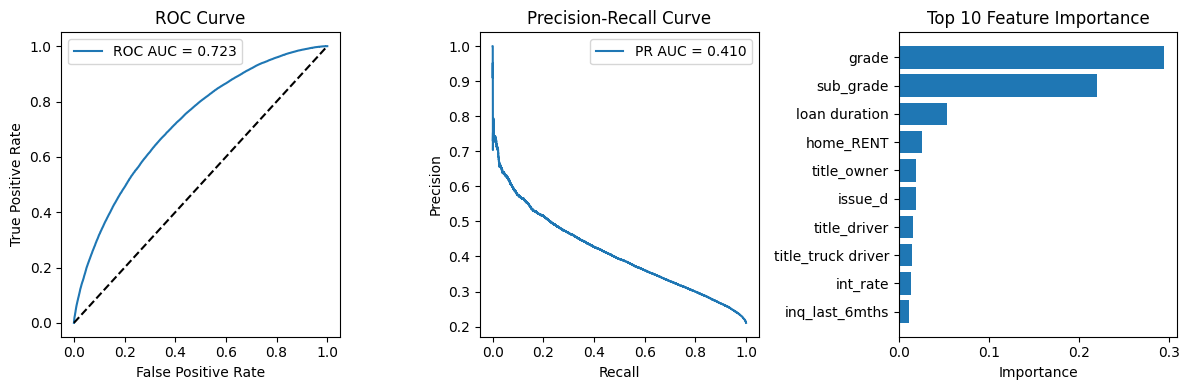


Modèle final sauvegardé avec AUC = 0.7227


In [94]:
print("ANALYSE DU MODÈLE")
print("="*50)

# Courbe ROC
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, results['y_proba'])

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f'ROC AUC = {results["roc_auc"]:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Courbe Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, results['y_proba'])
plt.subplot(1, 3, 2)
plt.plot(recall, precision, label=f'PR AUC = {results["pr_auc"]:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# Feature Importance
plt.subplot(1, 3, 3)
top_features = results['feature_importance'].head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\nModèle final sauvegardé avec AUC = {results['roc_auc']:.4f}")